#**Trading NVIDIA stock with SOTA Proximal Policy Optimisation Agent**

PPO is a general-purpose, actor-critic based, deep reinforcement learning algorithm that has been designed by [OpenAI](https://openai.com/research/openai-baselines-ppo) in 2017 for robotic locomotion & simulation in 3D environments. However, I thought it could work well for algorithmic trading as most algorithms used in trading are first backtested in an engine such as [Zipline](https://zipline.ml4trading.io/index.html) which simulates a real trading environment.

The image below is taken from a slide from a lecture by UC Berkley's Robotic AI & Learning lab ([CS 294-112: Deep Reinforcement Learning by Sergey Levine](http://rail.eecs.berkeley.edu/deeprlcourse-fa17/f17docs/lecture_10_imitating_optimal_control.pdf)) which shows what type of RL algorithm should be used under what circumstances. If we follow the tree:
1. Are you learning in a simulator?
Yes, we can use the gym [any trading environment](https://github.com/AminHP/gym-anytrading) as a simulator
2. Is simulation cost negligible compared to training cost? Yes, even when using an optimised version of PPO from [Stable Baselines3](https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html), training time (and cost) is much, much higher than simulation time.
3. We are left with Policy Gradient (e.g. REINFORCE, VPG, A3C, GAE, A2C), and Actor-Critic (e.g. DDPG, TD3, SAC, PPO)

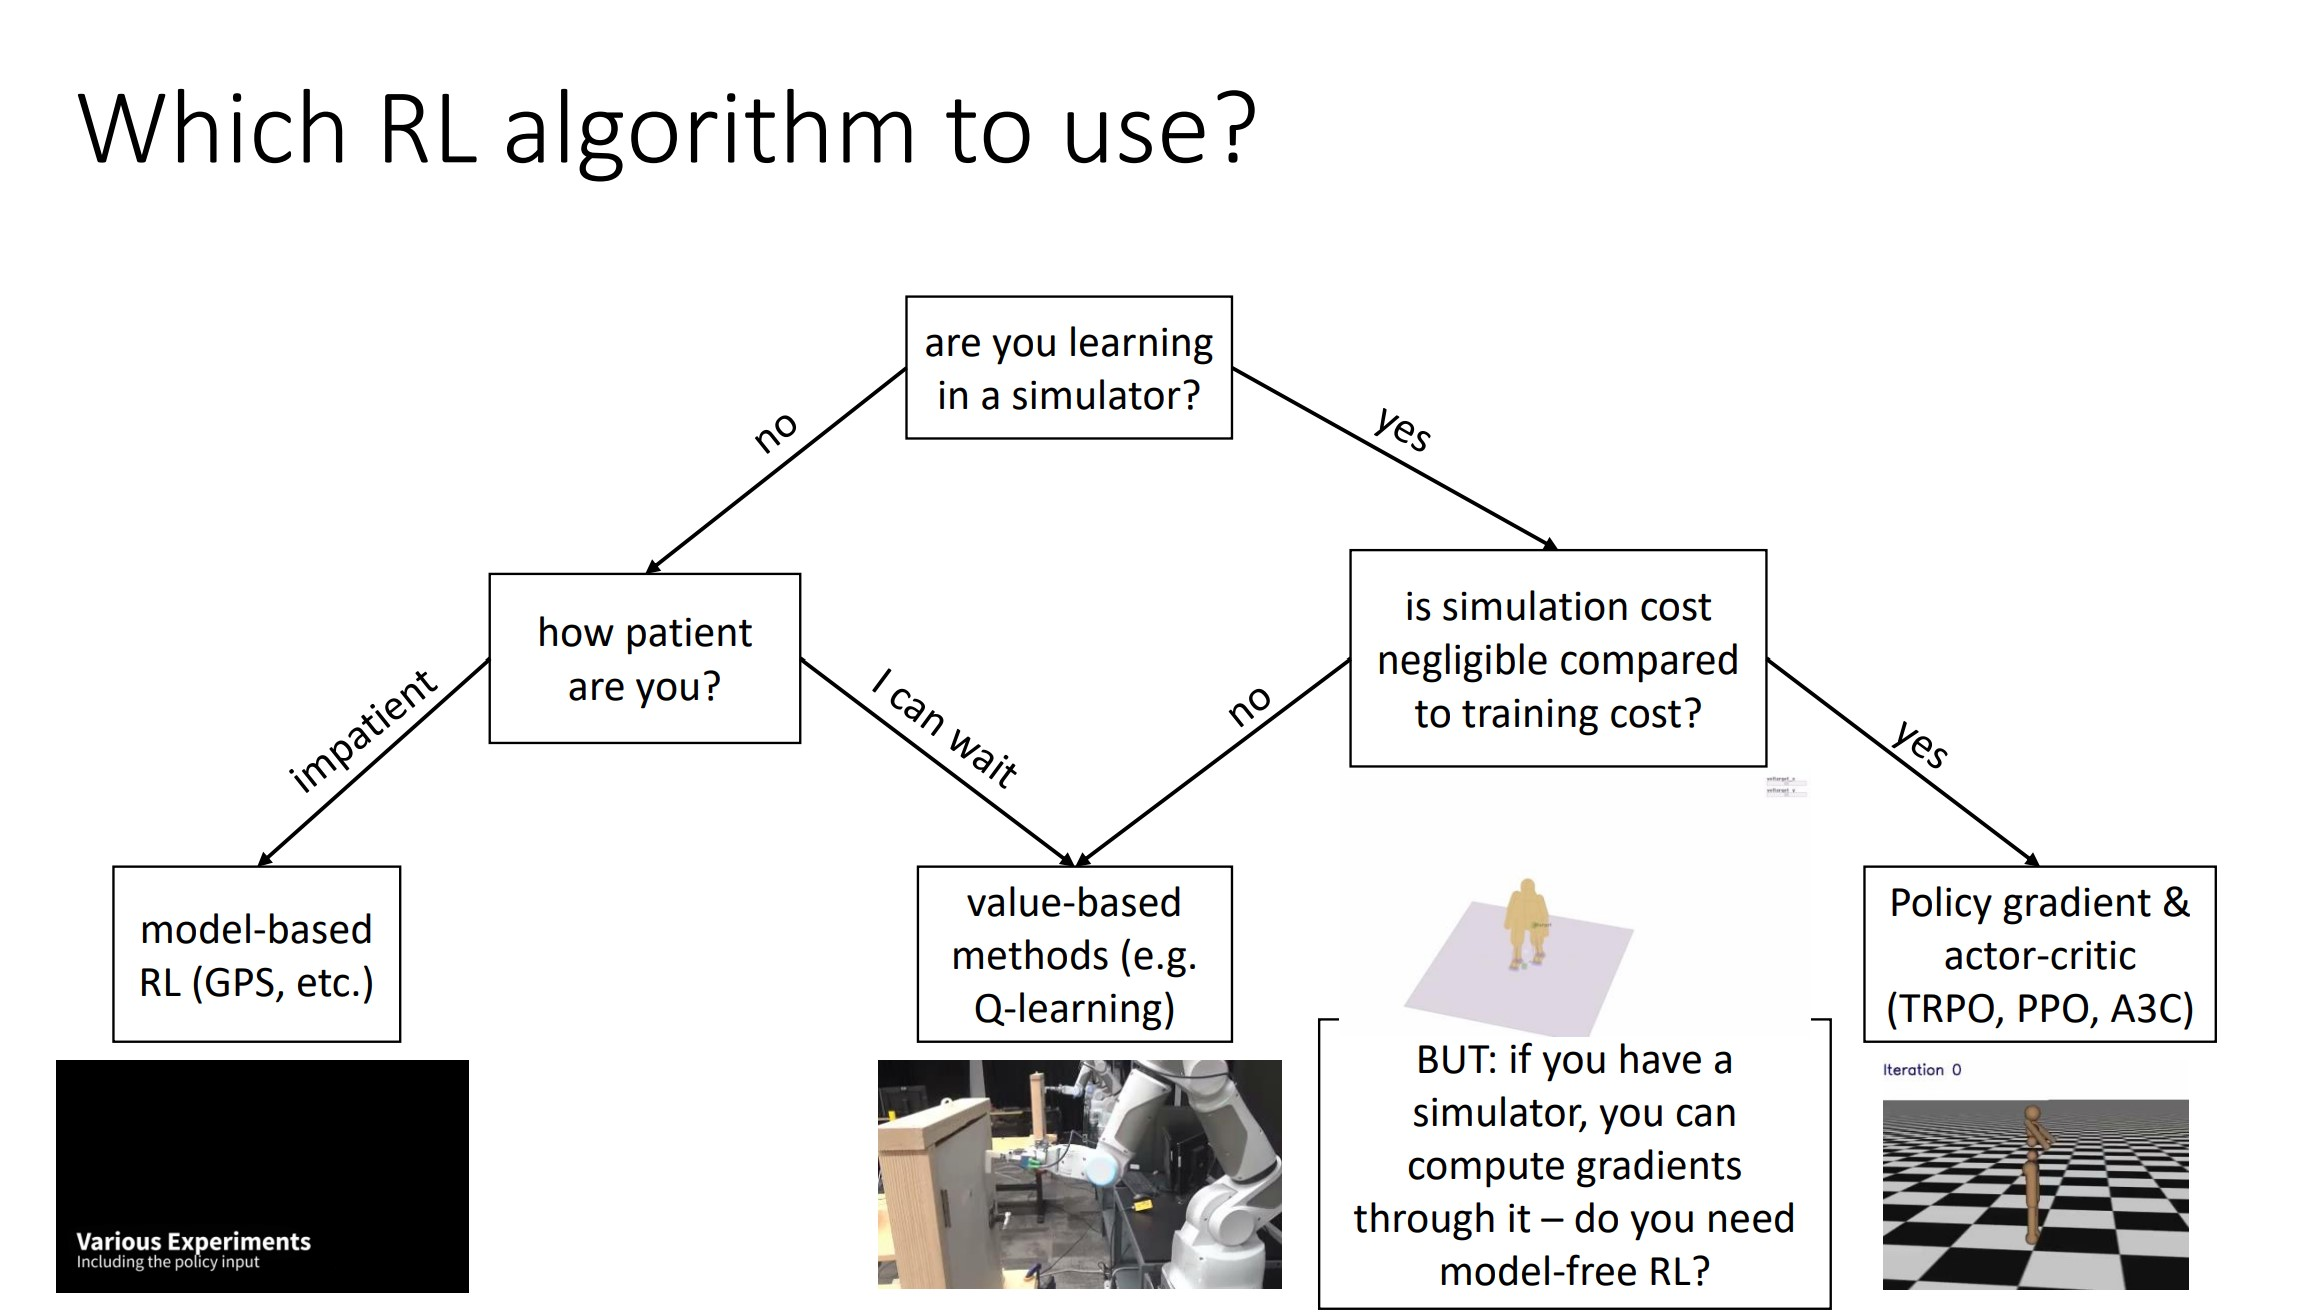

> **PPO [paper](https://arxiv.org/abs/1707.06347) abstract:**
We propose a new family of policy gradient methods for reinforcement learning, which alternate between sampling data through interaction with the environment, and optimizing a "surrogate" objective function using stochastic gradient ascent. Whereas standard policy gradient methods perform one gradient update per data sample, we propose a novel objective function that enables multiple epochs of minibatch updates. The new methods, which we call proximal policy optimization (PPO), have some of the benefits of trust region policy optimization (TRPO), but they are much simpler to implement, more general, and have better sample complexity (empirically). Our experiments test PPO on a collection of benchmark tasks, including simulated robotic locomotion and Atari game playing, and we show that PPO outperforms other online policy gradient methods, and overall strikes a favorable balance between sample complexity, simplicity, and wall-time.

## **Library Installation & Imports**

In [ ]:
!pip install gymnasium
!pip install stable_baselines3
!pip install gym_anytrading
!pip install quantstats

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gymnasium as gym
import gym_anytrading
from gym_anytrading.envs import Actions

from stable_baselines3 import PPO

import quantstats as qs

## **Data Loading & Processing**

##Dataset
The dataset is provided by Quandl which has been acquired by NASDAQ in 2018. In 2021, NASDAQ integrated Quandl's data platform. Free US equity data is still available (as of September 2023).

NASDAQ makes available a dataset with stock prices, dividends and splits for 3,000 US publicly traded companies. The historical data is useful as a first step towards demonstrating the application of the machine learning solutions, just ensure you design and test your own models using current, professional, paid data before investing in the market.

>In order to get the final dataset for NVIDIA stock data:
1.   Follow the instructions to create a [free NASDAQ account](https://data.nasdaq.com/sign-up)
2.   Download the entire [WIKI_PRICES](https://data.nasdaq.com/tables/WIKIP/WIKI-PRICES/export) data as a zip file
3. Upload the zip file to your google drive
4. Dock your google drive to your colab environment
5. Unzip the zipfile in your colab environment
6. Run the remaining code to process the data so the libraries can read it






In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile

# Get the path to the zip file
zip_file_path = "/content/drive/MyDrive/WIKI_PRICES_212b326a081eacca455e13140d7bb9db.zip"

# Create a ZipFile object
with zipfile.ZipFile(zip_file_path, "r") as zip_file:
    # Extract all the files in the zip file to the current directory
    zip_file.extractall()

import pandas as pd

df = pd.read_csv("/content/WIKI_PRICES_212b326a081eacca455e13140d7bb9db.csv")

# Locate the desired stock
data = df.loc[df['ticker'] == 'NVDA']

# Convert data to datetime type
data['date'] = pd.to_datetime(data['date'])
df.dtypes

# Set Date as the index
data.set_index('date', inplace=True)

#df = data.drop(['ticker','ex-dividend', 'split_ratio', 'adj_open', 'adj_high', 'adj_low', 'adj_volume'], axis=1)
# can be used to drop certain columns/features deemed unnecessary
df = data
df.head()

,ticker,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume
date,,,,,,,,,,,,,
1999-01-22,NVDA,21.00,23.44,18.63,19.69,5655600.0,0.0,1.0,1.623824,1.812497,1.440564,1.522529,67867200.0
1999-01-25,NVDA,21.25,22.00,19.69,21.75,1063500.0,0.0,1.0,1.643156,1.701149,1.522529,1.681818,12762000.0
1999-01-26,NVDA,22.00,22.44,19.75,20.06,715000.0,0.0,1.0,1.701149,1.735172,1.527168,1.551139,8580000.0
1999-01-27,NVDA,20.13,20.63,19.00,20.00,509100.0,0.0,1.0,1.556552,1.595214,1.469174,1.546499,6109200.0
1999-01-28,NVDA,20.00,20.13,19.81,19.94,474000.0,0.0,1.0,1.546499,1.556552,1.531808,1.541860,5688000.0


Further processing and feature engineering could be done
e.g. winzorisation or gathering a dataset with more features than the basic OHLCV however, this is just a proof of concept.

In [ ]:
# The any_trading environment & stablebaselines requires features to start with a capital letter
def capitalize_column_names(df):
    new_column_names = []
    for column_name in df.columns:
        new_column_name = column_name.capitalize()
        new_column_names.append(new_column_name)
    df.columns = new_column_names

capitalize_column_names(df)

In [ ]:
df

,Ticker,Open,High,Low,Close,Volume,Ex-dividend,Split_ratio,Adj_open,Adj_high,Adj_low,Adj_close,Adj_volume
date,,,,,,,,,,,,,
1999-01-22,NVDA,21.00,23.44,18.630,19.69,5655600.0,0.0,1.0,1.623824,1.812497,1.440564,1.522529,67867200.0
1999-01-25,NVDA,21.25,22.00,19.690,21.75,1063500.0,0.0,1.0,1.643156,1.701149,1.522529,1.681818,12762000.0
1999-01-26,NVDA,22.00,22.44,19.750,20.06,715000.0,0.0,1.0,1.701149,1.735172,1.527168,1.551139,8580000.0
1999-01-27,NVDA,20.13,20.63,19.000,20.00,509100.0,0.0,1.0,1.556552,1.595214,1.469174,1.546499,6109200.0
1999-01-28,NVDA,20.00,20.13,19.810,19.94,474000.0,0.0,1.0,1.546499,1.556552,1.531808,1.541860,5688000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-21,NVDA,249.32,252.00,247.330,248.56,10841782.0,0.0,1.0,249.320000,252.000000,247.330000,248.560000,10841782.0
2018-03-22,NVDA,246.00,247.88,240.341,241.85,13663927.0,0.0,1.0,246.000000,247.880000,240.341000,241.850000,13663927.0
2018-03-23,NVDA,242.40,242.67,232.520,232.97,18225390.0,0.0,1.0,242.400000,242.670000,232.520000,232.970000,18225390.0


## **Creating Gym Trading Environment**

In [ ]:
window_size = 10
start_index = window_size
end_index = len(df)

env = gym.make(
    'stocks-v0',
    df=df,
    window_size=window_size,
    frame_bound=(start_index, end_index)
)

print("observation_space:", env.observation_space)

observation_space: Box(-10000000000.0, 10000000000.0, (10, 2), float32)


## **Training Environment**

In [ ]:
env.reset(seed=2023)
model = PPO('MlpPolicy', env, verbose=0)
model.learn(total_timesteps=350000)

## **Testing Environment**

In [ ]:
action_stats = {Actions.Sell: 0, Actions.Buy: 0}

observation, info = env.reset(seed=2023)

while True:
    action, _states = model.predict(observation)

    action_stats[Actions(action)] += 1
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    if done:
        break

env.close()

print("action_stats:", action_stats)
print("info:", info)

action_stats: {<Actions.Sell: 0>: 62, <Actions.Buy: 1>: 4752}
info: {'total_reward': 308.1391067504883, 'total_profit': 12.21934266604043, 'position': <Positions.Long: 1>}


## **Plotting Results**

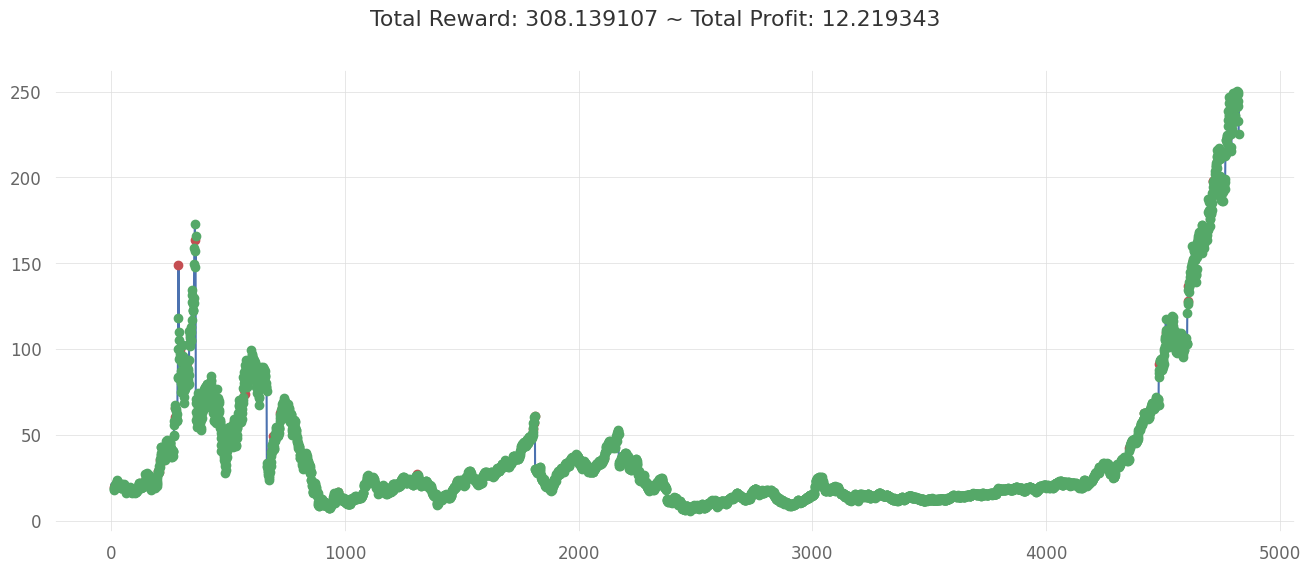

In [ ]:
plt.figure(figsize=(16, 6))
env.unwrapped.render_all()
plt.show()

## **Portfolio Analysis Using `quantstats`**

[Performance Metrics]



                           Strategy
-------------------------  ----------
Start Period               1999-02-09
End Period                 2018-03-27
Risk-Free Rate             0.0%
Time in Market             2.0%

Cumulative Return          1,121.93%
CAGR﹪                     9.45%

Sharpe                     0.5
Prob. Sharpe Ratio         99.54%
Smart Sharpe               0.5
Sortino                    1.04
Smart Sortino              1.04
Sortino/√2                 0.74
Smart Sortino/√2           0.73
Omega                      2.6

Max Drawdown               -92.17%
Longest DD Days            6254
Volatility (ann.)          54.15%
Calmar                     0.1
Skew                       14.87
Kurtosis                   636.26

Expected Daily %           0.05%
Expected Monthly %         1.09%
Expected Yearly %          13.33%
Kelly Criterion            38.95%
Risk of Ruin               0.0%
Daily Value-at-Risk        -5.5%
Expected Shortfall (cVaR)  -5.5%

Max Consecutive Wins      

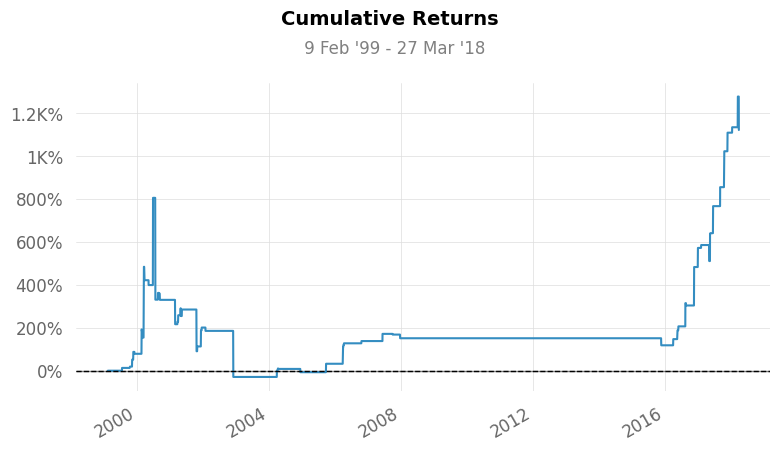

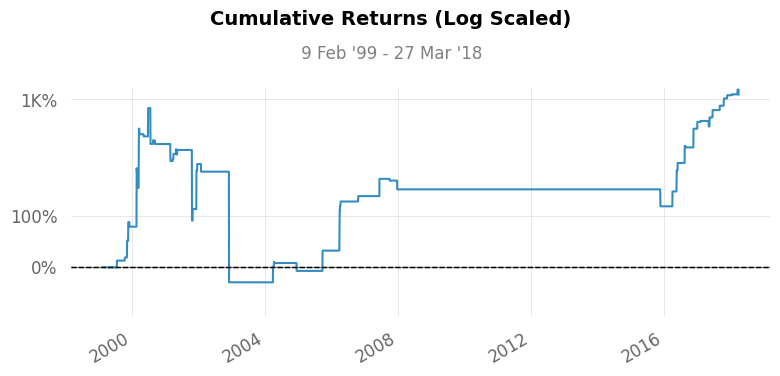

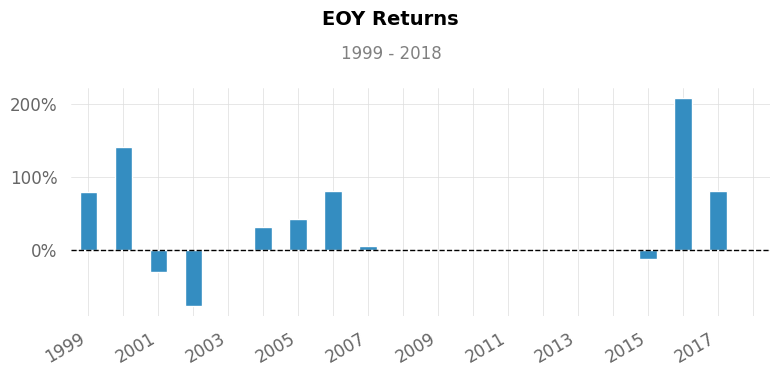

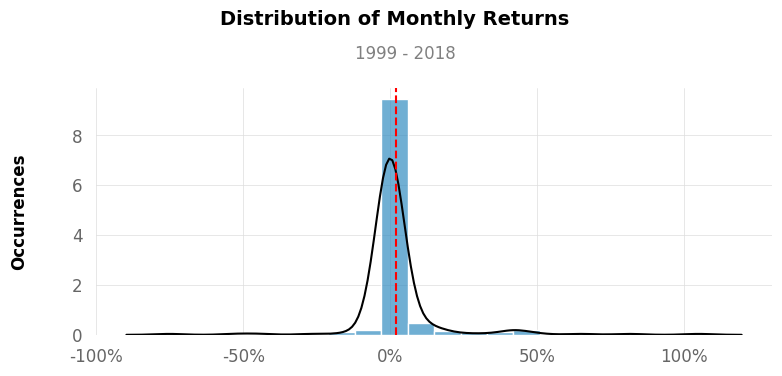

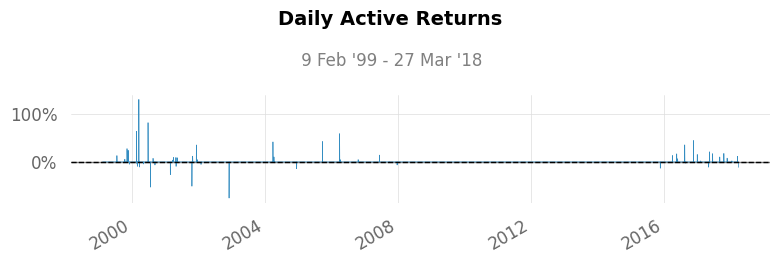

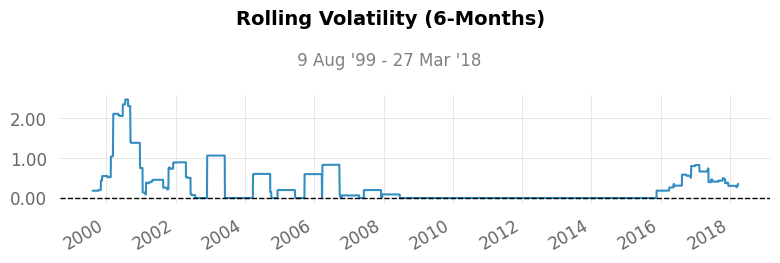

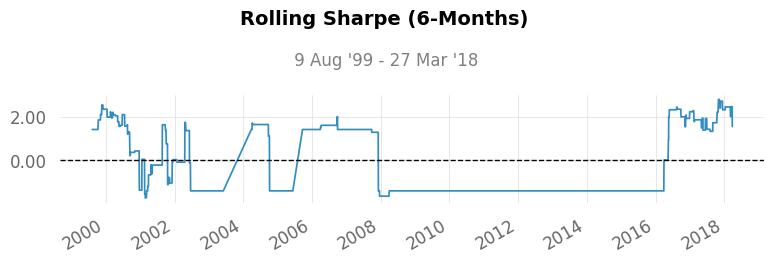

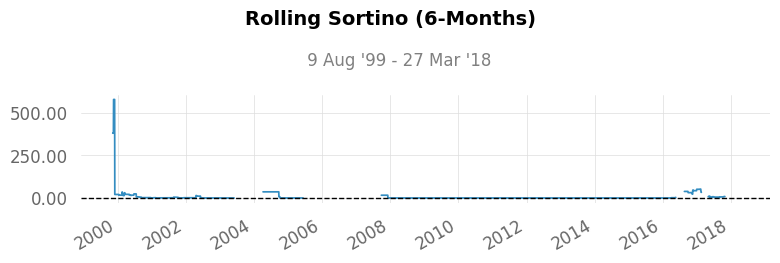

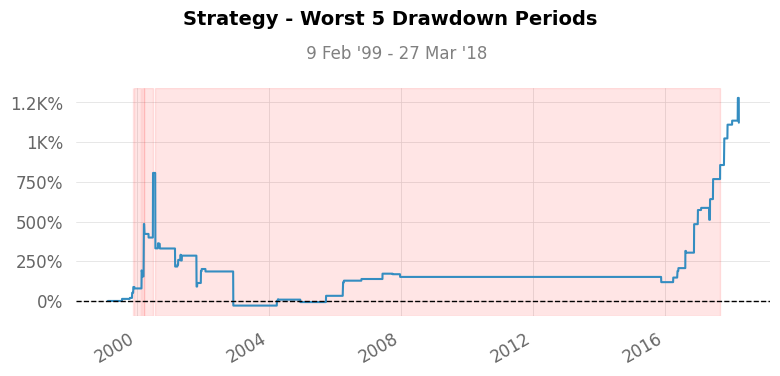

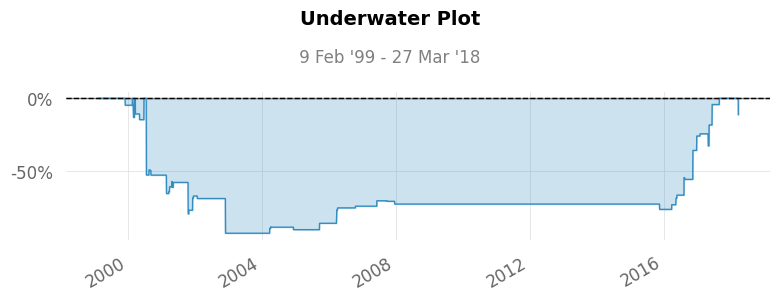

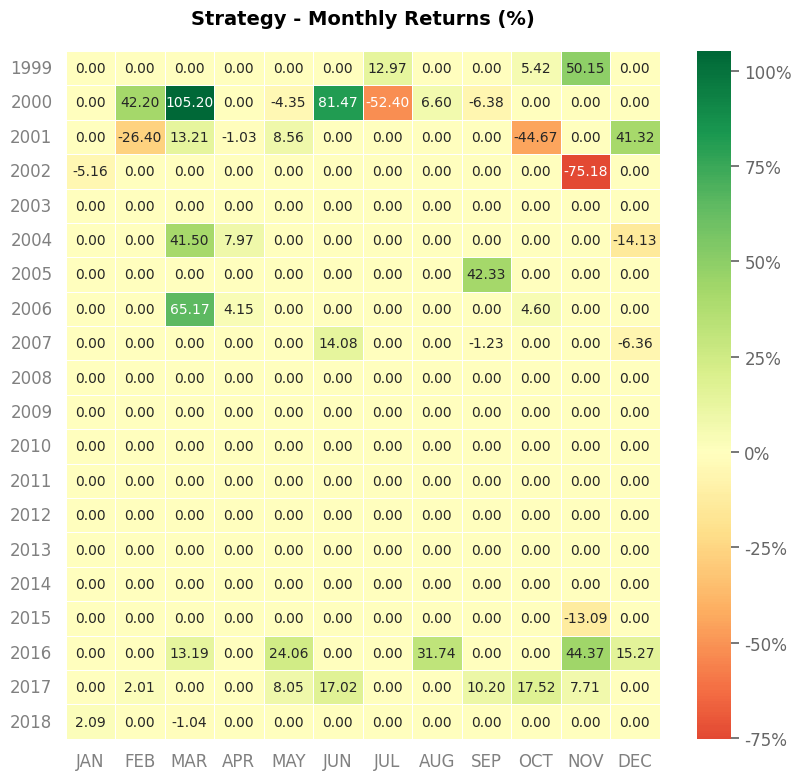

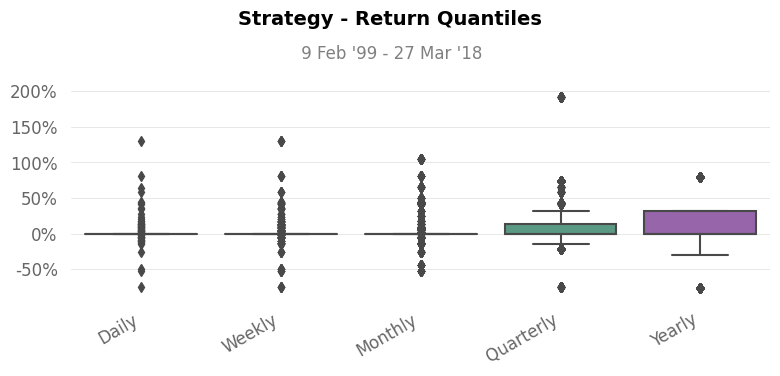

In [ ]:
qs.extend_pandas()

net_worth = pd.Series(env.unwrapped.history['total_profit'], index=df.index[start_index+1:end_index])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)
qs.reports.html(returns, output='NVIDIA_PPO_quantstats.html') # creates .html file with tear sheet

Check the NVIDIA_PPO_quantstats.html file for full and clearer view of tear sheet

The main statistics to look at are the CAGR (Compound Aggregate Growth Rate) and the Sharpe Ratio (compares the return of an investment with its risk), the PPO agent achieves a (annual) CAGR of 9.45% and a Sharpe Ration of 0.5. Now compared to average returns provided by Hedge funds: according to [Barclay Hedge](https://www.forbes.com/sites/jacobwolinsky/2022/08/30/heres-how-the-top-50-hedge-funds-generate-consistent-returns/), "the average hedge fund generated net annualized returns of 7.2% with a Sharpe ratio of 0.86 and market correlation of 0.9 over the last five years through 2021".

> This means that the PPO agent outperforms the average human run hedge fund in terms of returns (take this with a grain of salt), however the sharpe ratio is much lower - this could be because the agent is only trading one asset whereas most hedge funds are highly diversified.

The PPO agent could be improved by e.g.:

1. Using minute-by-minute data (usually very expensive and computationally difficult) instead of daily data
2. Fine tune model parameters and extend training time steps
3. Use custom optimised PPO implementation for stock trading
4. Implement further data processing & feature engineering